In [1]:
%matplotlib inline
%matplotlib widget
#%matplotlib notebook
import json
import os
import pprint
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import math
import numpy as np
import pandas as pd
import textwrap

import ipywidgets as widgets
from ipywidgets import HBox, VBox
from ipywidgets import interact, interact_manual, Layout
import IPython.display
from IPython.display import display, clear_output
import mplcursors
from matplotlib.legend_handler import HandlerLine2D
from collections import Counter
from matplotlib.animation import FuncAnimation
call = [None]

#import plotly.graph_objects as go

In [2]:
class digest_query:
    def __init__(self, query_id, digest, digest_text, time_ms, cpu_usage, io, count, timestamp):
        self.query_id = query_id
        self.digest = digest
        self.digest_text = digest_text
        self.value = [[timestamp, time_ms, cpu_usage, io, count]]
        self.time_ms = []
        self.cpu_usage = []
        self.io = []
        self.count = []
        self.timestamp = []
    
    def add_time(self, time_ms):
        self.value[-1][1]+=time_ms
    
    def add_timestamp(self, time_ms, cpu_usage, io, count, timestamp):
        self.value.append([timestamp, time_ms, cpu_usage, io, count])
    
    def print_digest_query(self):
        print(f'query_id={self.query_id}')
        print(f'digest={self.digest}')
        print(f'digest_text={self.digest_text}')
        print(f'time_ms={self.time_ms}')
        print(f'cpu_usage={self.cpu_usage}')
    
    def sort_timestamp(self):
        self.value = list(map(lambda x: [x[0], float(x[1]), float(x[2]), int(x[3]), int(x[4])], self.value))
        self.value = sorted(self.value, key=lambda x:x[0])
        for v in self.value:
            self.time_ms.append(v[1]) 
            self.cpu_usage.append(v[2])
            self.timestamp.append(v[0])
            self.count.append(v[4])
            self.io.append(v[3])
        #new_count = list(np.diff(np.array(self.count)))
        #new_count.insert(0, 0)
        #print(new_count)
    
    def add_missing_value(self, all_timestamp):
        new_time_ms = []
        new_cpu_usage = []
        new_count = []
        new_io = []
        #print(all_timestamp)
        #print(self.timestamp)
        for time in all_timestamp:
            if time in self.timestamp: #b에서 val의 index
                new_time_ms.append(self.time_ms[self.timestamp.index(time)])
                new_cpu_usage.append(self.cpu_usage[self.timestamp.index(time)])
                new_count.append(self.count[self.timestamp.index(time)])
                new_io.append(self.io[self.timestamp.index(time)])
            else:
                new_time_ms.append(0)
                new_cpu_usage.append(0)
                new_count.append(0)
                new_io.append(0)
        #print(len(all_timestamp), len(new_time_ms), len(new_cpu_usage))
        self.time_ms = new_time_ms
        self.cpu_usage = new_cpu_usage
        self.count = new_count
        self.io = new_io


def import_data(path):
    dic = {}
    query_num = 0
    all_timestamp =[]
    file_list = os.listdir(path)
    for filename in file_list:
        with open(os.path.join(path, filename), 'r') as f:
            # 같은 파일 내를 탐색
            file_datetime = dt.datetime.strptime(filename,'%Y%m%d_%H%M%S') 
            all_timestamp.append(file_datetime)
            text = json.load(f)
            #io = text['metrics_data']["global"]["engine"]["innodb_status_io"]
            performance_schema = text['metrics_data']['global']['performance_schema']
            threads = performance_schema['threads']       
            tid_dic = {i[0]['thread_id']:i[0]['thread_os_id'] for i in threads}
            cpu_usage = performance_schema['cpu_usage'] # thread_os_id : cpu_usage
            io = performance_schema['io'] 
            events_statements_history = performance_schema['events_statements_history'] # list of dic
            digest_list = []
            for event in events_statements_history:
                digest = event['digest']
                if digest is None:
                    continue
                #print(type(digest))
                thread_id = event['thread_id']
                digest_text = event['digest_text']
                count = event['count']
                time = event['time_ms']
                if digest in digest_list: # 같은 쿼리가 같은 시간대에 이미 존재할 경우? time만 합친다.
                    dic[digest].add_time(time)
                elif digest in dic.keys():
                    if str(tid_dic[thread_id]) in io.keys():
                        dic[digest].add_timestamp(time, cpu_usage[str(tid_dic[thread_id])], io[str(tid_dic[thread_id])], count, file_datetime)
                    else:
                        dic[digest].add_timestamp(time, cpu_usage[str(tid_dic[thread_id])], 0, count, file_datetime)
                else:
                    if str(tid_dic[thread_id]) in io.keys():
                        temp = digest_query(query_num, digest, digest_text, time, cpu_usage[str(tid_dic[thread_id])], io[str(tid_dic[thread_id])], count, file_datetime)
                    else:
                        temp = digest_query(query_num, digest, digest_text, time, cpu_usage[str(tid_dic[thread_id])], 0, count, file_datetime)
                    #key error 발생
                    dic[digest] = temp
                    query_num+=1
                digest_list.append(digest)
    all_timestamp.sort()
    for query in dic:
        query_id = dic[query].query_id
        dic[query].sort_timestamp()
    return dic, all_timestamp

def rank(dic, type, num):
    def Average(lst):
        return sum(lst) / len(lst)
    rank_list = []
    dic_by_id={}
    for query in dic:
        query_id = dic[query].query_id
        dic_by_id[query_id] = dic[query]
        rank_list.append((dic[query].query_id, Average(dic[query].time_ms), Average(dic[query].cpu_usage), Average(dic[query].io), Average(dic[query].count)))
        dic[query].add_missing_value(all_timestamp)
    
    if type == 'CPU':
        cpu_top = sorted(rank_list, key=lambda x:-x[2])[:num]
        cpu_top_qid = [i[0] for i in cpu_top]
        return cpu_top_qid
    elif type == 'Duration':
        time_top = sorted(rank_list, key=lambda x:-x[1])[:num]
        time_top_qid = [i[0] for i in time_top]
        return time_top_qid
    elif type == 'Disk IO':
        disk_top = sorted(rank_list, key=lambda x:-x[3])[:num]
        disk_top_qid = [i[0] for i in disk_top]
        return disk_top_qid
    elif type == 'Execution Count':
        count_top = sorted(rank_list, key=lambda x:-x[4])[:num]
        count_top_qid = [i[0] for i in count_top]
        return count_top_qid

In [3]:
#fig, ax = plt.subplots(figsize=(10, 7))
y1_max=0
y2_max=0

path = "data"
dic, all_timestamp = import_data(path)


def visualize(type, num, time_range, m_agg='avg'):
    def update_prop(handle, orig):
            handle.update_from(orig)
            x,y = handle.get_data()
            handle.set_data([np.mean(x)]*2, [0, 2*y[0]])
    def resample(inp_array,window_size,how='avg'):
        inp_array = np.asarray(inp_array)

        #check how many zeros need to be added to the end to make
        #   the array length a multiple of window_size 
        pad = (window_size-(inp_array.size % window_size)) % window_size
        if pad > 0:
            inp_array = np.r_[np.ndarray.flatten(inp_array),np.zeros(pad)]
        else:
            inp_array = np.ndarray.flatten(inp_array)

        #reshape so that the number of columns = window_size
        inp_windows = inp_array.reshape((inp_array.size//window_size,window_size))

        if how == 'max':
           #sum across columns
           return np.max(inp_windows,axis=1)
        elif how == 'avg':
            return np.average(inp_windows,axis=1)
        elif how == 'min':
            return np.min(inp_windows,axis=1)
        else:
            raise NotImplementedError #replace this with other how's you want


    if type == 'CPU':
        def do_animation():
            fig = plt.figure(1)
            plt.close(1)
            def visualize_CPU(i):
                dic, all_timestamp = import_data(path)
                plt.cla()
                cpu_top_qid = rank(dic, 'CPU', num)
                for query in dic:
                    if dic[query].query_id in cpu_top_qid:
                        x = all_timestamp
                        y = np.array(dic[query].cpu_usage, dtype=np.float64)

                        x = x[:2500+30*i]
                        y = y[:2500+30*i] # Truncate

                        x = x[::30]
                        y = resample(y, 30, how=m_agg) # Rollup, Aggregate

                        plt.plot_date(x, y, xdate = True, ms=0,  ls = '-',label=str(dic[query].query_id) + " "+ dic[query].digest_text[:20])
                plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5),handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
                plt.title(f"CPU usage per query\nfor queries with top {num} CPU usage", size=20, fontweight="bold")
                plt.xlim(x[-1]-time_range,x[-1])
                plt.gcf().autofmt_xdate()
                plt.grid(True, axis='y')
                plt.tight_layout()
                mplcursors.cursor(plt.gcf(), highlight=True, hover = True)
            call[0] = FuncAnimation(plt.gcf(), visualize_CPU, interval = 10000)
            #return call
        #call_save = 
        do_animation()
#         plt.gcf().autofmt_xdate()
#         plt.grid(True, axis='y')
#         plt.tight_layout()
#         mplcursors.cursor(plt.gcf(), highlight=True, hover = True)    
        plt.show()
    elif type == 'Duration':
        fig = plt.figure(2)
        time_top_qid = rank(dic,'Duration', num)
        for query in dic:
            if dic[query].query_id in time_top_qid:
                x = all_timestamp
                y = np.array(dic[query].time_ms, dtype=np.float64)
                x = x[:2500]
                y = y[:2500]
                x = x[::30]
                y = resample(y, 30, how=m_agg)
                plt.plot_date(x, y, xdate = True, ms=0, ls = '-', label=str(dic[query].query_id)+ " " + dic[query].digest_text[:20])#, bottom = bottom2)
        plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
        plt.title(f"Query latency\nfor top {num} slowest queries", size=20, fontweight="bold")

    
    elif type == 'Disk IO':
        fig = plt.figure(3)
        disk_top_qid = rank(dic,'Disk IO', num)
        for query in dic:
            if dic[query].query_id in disk_top_qid:
                x = all_timestamp
                y = np.array(dic[query].io, dtype=np.float64)
                x = x[:2500]
                y = y[:2500]
                x = x[::30]
                y = resample(y, 30, how=m_agg)
                plt.plot_date(x, y, xdate = True, ms=0,  ls = '-', label=str(dic[query].query_id)+ " " + dic[query].digest_text[:20])#, bottom = bottom2)
        plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
        plt.title(f"Disk IO per query\nfor queries with top {num} Disk IO", size=20, fontweight="bold")


    elif type == 'Execution Count':
        fig = plt.figure(4)
        count_top_qid = rank(dic,'Execution Count', num)
        for query in dic:
            if dic[query].query_id in count_top_qid:
                x = all_timestamp
                y = np.array(dic[query].count, dtype=np.float64)
                x = x[:2500]
                y = y[:2500]
                x = x[::30]
                y = resample(y, 30, how=m_agg)
                plt.plot_date(x, y, xdate = True, ms=0,  ls = '-', label=str(dic[query].query_id)+ " " + dic[query].digest_text[:20])#, bottom = bottom2)
        plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
        plt.title(f"Execution Count for queries\nwith top {num} execution count", size=20, fontweight="bold")
    
    

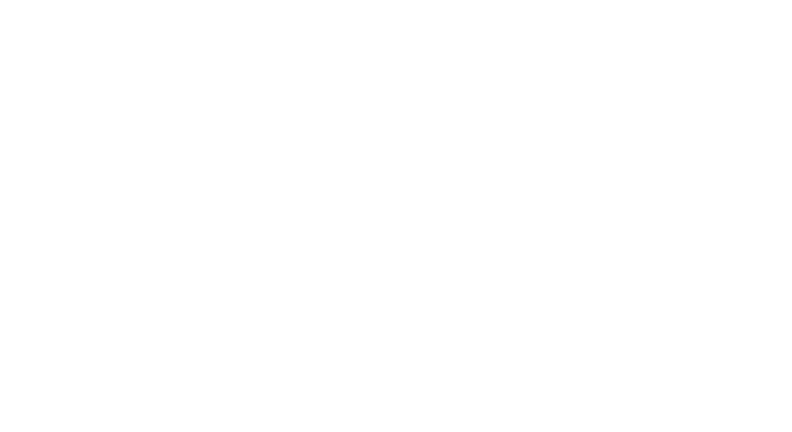

In [4]:
style = {'description_width': 'initial'}
layout = widgets.Layout(
                align_items='center',
                width= '80%',
)

w1 = widgets.Dropdown(
    options=['CPU', 'Disk IO', 'Duration', 'Execution Count'],
    value='CPU',
    #description='Metric type:',
    style = style,
    layout = layout,
)
w2 = widgets.Dropdown(
    options=['Last 1 min', 'Last 10 min','Last 1 hr', 'Last 6 hrs', 'Last 24 hrs', 'past week', 'past month', 'custom'],
    value='Last 10 min',
    #description='Time Period:',
    style = style,
    layout = layout,
)
w3 = widgets.Dropdown(
    options=['5','10','15'],
    value='5',
    #description='# of queries:',
    style = style,
    layout=Layout(flex='1 1 25%', align_items='center', width='80%'),
)
w4 = widgets.Dropdown(
    options=['Not implemented yet'],
    value='Not implemented yet',
    #description='Query aggregation:',
    style = style,
    layout = layout,
)
w5 = widgets.Dropdown(
    options=['avg','min','max'],
    value='avg',
    #description='Metrics aggregation:',
    style = style,
    layout = layout,
)

button = widgets.Button(description='Draw', color = 'blue',
                        layout=Layout(flex='2 1 50%', align_items='center', width='80%'),)



def on_click_callback(clicked_button: widgets.Button) -> None:
    """버튼이 눌렸을 때 동작하는 이벤트 핸들러"""
    plt.close(1)
    plt.close(2)
    plt.close(3)
    plt.close(4)
    num= int(w3.value)
    if w2.value == 'Last 1 min':
        time_range = dt.timedelta(minutes = 1)
    elif w2.value == 'Last 10 min':
        time_range = dt.timedelta(minutes = 10)
    elif w2.value == 'Last 1 hr':
        time_range = dt.timedelta(hours = 1)
    elif w2.value == 'Last 6 hrs':
        time_range = dt.timedelta(hours = 6)
    elif w2.value == 'Last 24 hrs':
        time_range = dt.timedelta(hours = 24)
    clear_output(wait = True)
    display(HBox(widget_list))
    visualize(w1.value, num, time_range, w5.value)

plt.figure(1) # CPU
plt.figure(2) # Duration
plt.figure(3) # Disk IO
plt.figure(4) # Execution Count
plt.close(1)
plt.close(2)
plt.close(3)
plt.close(4)
clear_output(wait = True)
plt.rcParams['figure.figsize'] = [11, 6]
plt.rcParams["date.autoformatter.minute"] = "%Y-%m-%d %H:%M:%S"
plt.ion()


lb1 = widgets.Label('Metrics type:')
lb2 = widgets.Label('Time period:')
lb3 = widgets.Label('# of queries:',layout=Layout(flex='1 1 25%', width='auto'))
lb4 = widgets.Label('Query aggregation:')
lb5 = widgets.Label('Metrics aggregation:')


button.on_click(on_click_callback)
h1 = VBox([lb1,w1,lb4, w4], layout = layout)
h2 = VBox([lb2,w2,lb5, w5], layout = layout)
h3 = VBox([lb3,w3, button], layout=widgets.Layout(flex_flow='column',align_items='center',
                width= '80%',))
widget_list = [h1,h2,h3]

display(HBox(widget_list, layout=Layout( width='auto')))

TypeError: 'type' object is not iterable

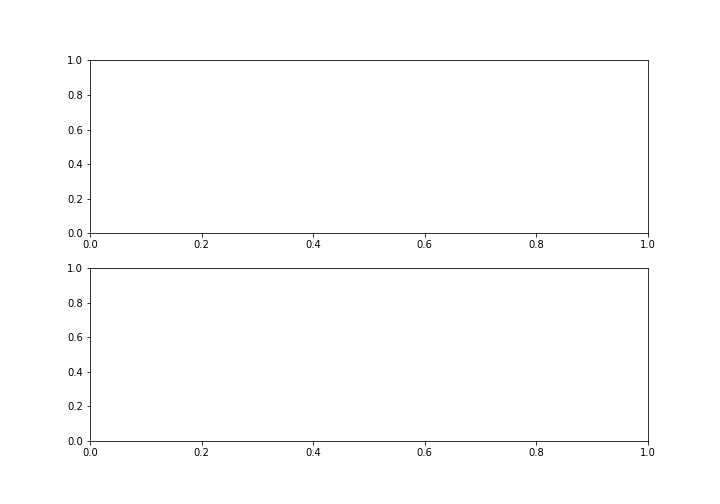

In [82]:
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import math


fig, axs = plt.subplots(2, figsize=(10, 7))
y1_max=0
y2_max=0
bottom1 = np.zeros(len(all_timestamp))
bottom2 = np.zeros(len(all_timestamp))
def sumzip(*items):
    return [sum(values) for values in zip(*items)]

for query in dict:
    #dict[query].print_digest_query()
    if dict[query].query_id in cpu_top5_qid:
        x = all_timestamp#[dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in all_timestamp]#dict[query].timestamp]
        y1 = np.array(dict[query].cpu_usage, dtype=np.float64)
        #y1_max = max(y1_max, max(y1))
        axs[0].bar(x, y1, width = 0.0001, label=str(dict[query].query_id) + " "+ dict[query].digest_text[:20], bottom = bottom1)
        print(dict[query].query_id)
        #print(x)
        #print(y1)
        bottom1 = y1 + bottom1


    if dict[query].query_id in time_top5_qid:
        qid=dict[query].query_id
        x = all_timestamp#[dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in all_timestamp]#dict[query].timestamp]
        y2 = np.array(dict[query].time_ms, dtype=np.float64)
        print(dict[query].query_id)
        #print(x)
        #print(y2)
        
        axs[1].bar(x, y2, width = 0.0001, label=str(dict[query].query_id)+ " " + dict[query].digest_text[:20], bottom = bottom2)
        #y2_max = max(y2_max, max(y2))
        bottom2 = y2 + bottom2
    


axs[0].set_yticks(np.linspace(0,max(bottom1),10))
axs[0].legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
axs[0].set_title("CPU usage per query for queries with top 5 CPU usage")
axs[1].set_yticks(np.linspace(0,max(bottom2),10))
axs[1].legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
axs[1].set_title("Query latency for top 5 slowest queries")


plt.tight_layout()

#plt.legend()
plt.show()
